## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [2]:
pip install --upgrade gdown

In [3]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [4]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [5]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.j

In [11]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [9]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

for i in range(10):
    img, target = coco_dset[i]
    print(f"Sample {i+1}:")
    print("Image Size: ", img.shape)
    print("Caption: ", target)
    print()

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Sample 1:
Image Size:  torch.Size([3, 224, 224])
Caption:  ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']

Sample 2:
Image Size:  torch.Size([3, 224, 224])
Caption:  ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view o

In [7]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [8]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [9]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [10]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [11]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

Image embeddings (40504, 512)


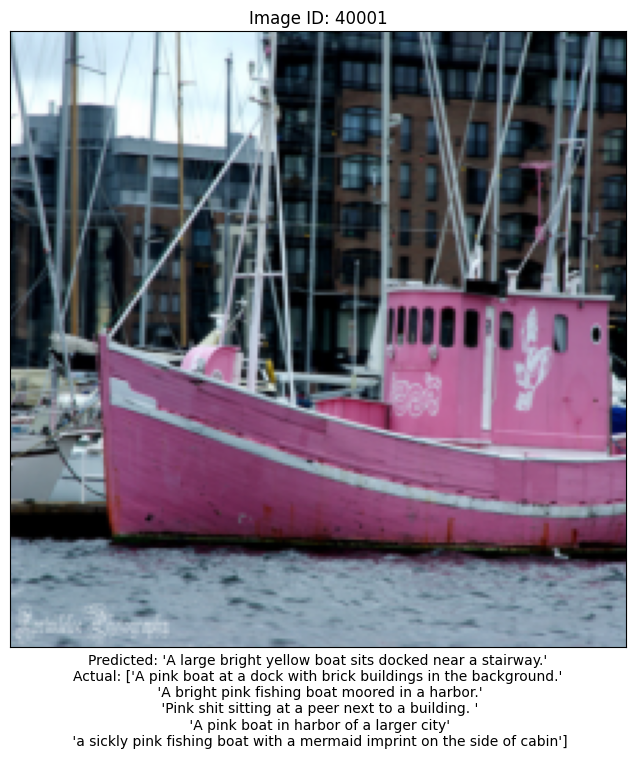

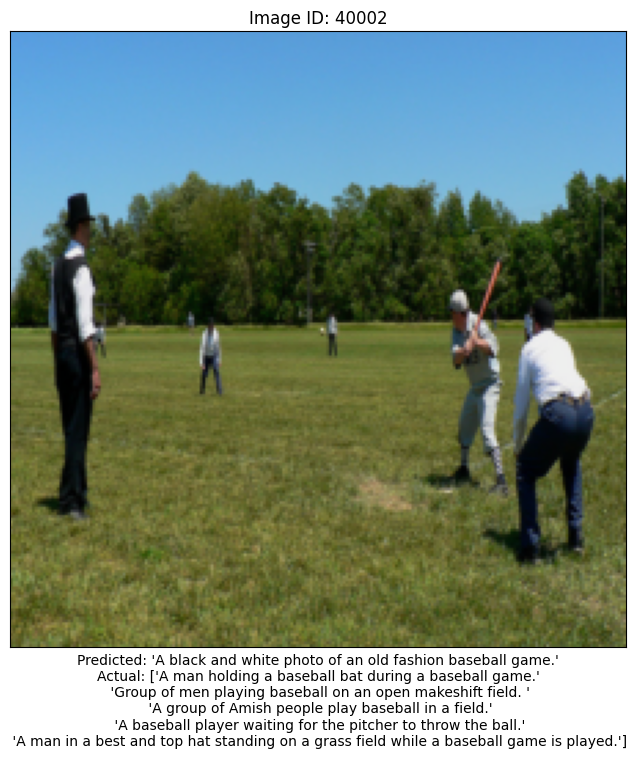

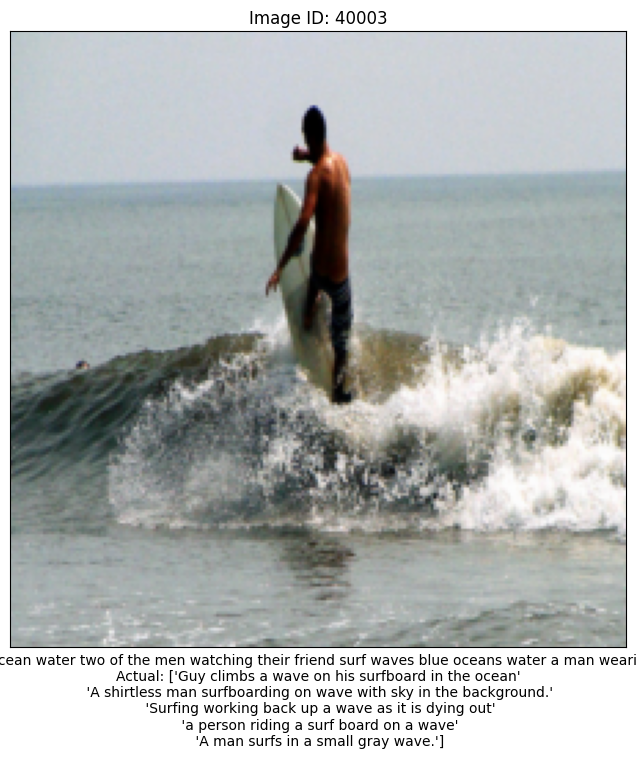

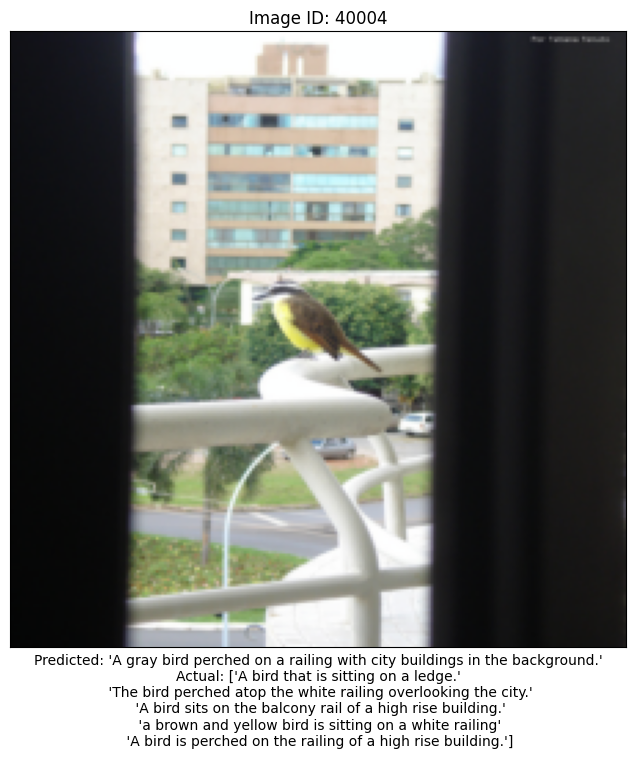

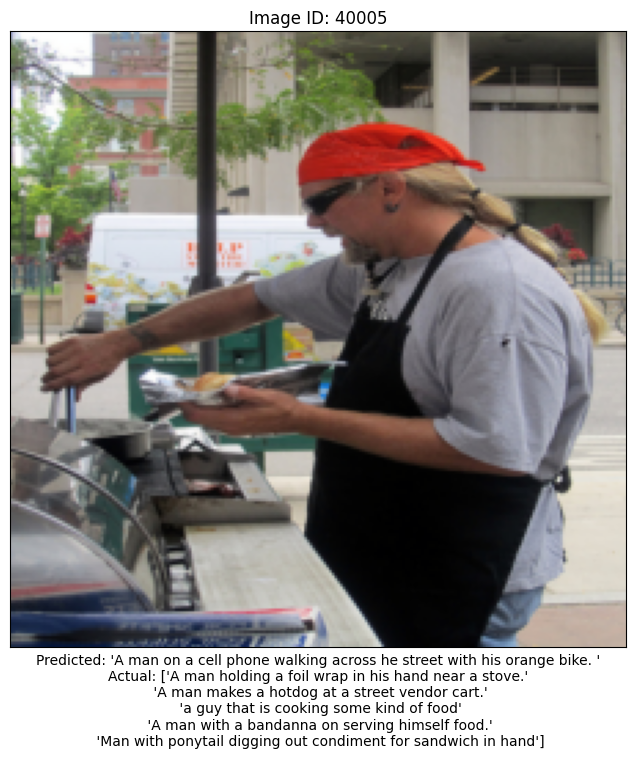

Best k: 2
Best BLEU Score: 0.026088727059135636


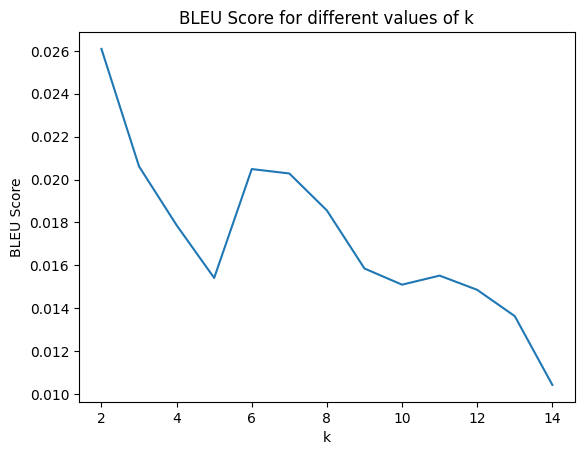

In [53]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate import bleu_score
import faiss
from scipy.spatial.distance import cosine


ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5])
captions_np = np.array(captions)

cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)

img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings', image_embeddings.shape)

def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()
    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy / len(predict)
def best_caption(q, caption_embeddings, indices):
    max_similarity = float('inf')
    best_caption_idx = None
    for index in indices:
        captions = caption_embeddings[index]
        for j, caption in enumerate(captions):
            cosine_distance = cosine(q, caption)
            cos_similarity = 1 - cosine_distance
            if max_similarity > cos_similarity:
                max_similarity = cos_similarity
                best_caption_idx = (index, j)
    return best_caption_idx
dimension = 512
faiss_index = faiss.IndexFlatL2(dimension)
for image_path in image_embeddings[:40000]:
    faiss_index.add(np.array(image_path, dtype='float32').reshape(1, -1))

results = {}
min_bs = -1
best_k = -1

for k in range(2, 15):
    actual = []
    predicted = []
    for i in range(40001, 40504):
        D, I = faiss_index.search(np.array(image_embeddings[i].reshape(1, -1), dtype='float32'), k)
        s = 1 + D[0]
        similarity = 1 / s
        nearest_caption_indices = I[0]
        nearest_caption_embeddings = caption_embeddings[nearest_caption_indices]
        similarities = similarity[:, np.newaxis, np.newaxis]
        elementwise_multiplication = nearest_caption_embeddings * similarities
        weighted_sum = np.sum(elementwise_multiplication, axis=(0, 1))
        q = weighted_sum / (k * 5)

        best_idx = best_caption(q, caption_embeddings, I[0])
        closest_caption = captions_np[best_idx[0]][best_idx[1]]

        actual.append(captions_np[i])
        predicted.append(closest_caption)

    bleu_scor = accuracy_v2(predicted, actual)
    results[k] = bleu_scor
    if max_bs < bleu_scor:
        best_k = k
        max_bs = bleu_scor

num_display = 5

for i in range(num_display):
    image_id = 40001 + i
    image, _ = coco_dset[image_id]
    actual_caption = actual_captions[i]
    predicted_caption = predicted_captions[i]

    np_image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = std * np_image + mean
    np_image = np.clip(np_image, 0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_image)
    plt.title(f"Image ID: {image_id}")
    plt.xlabel(f"Predicted: '{predicted_caption}'\nActual: {actual_caption}")
    plt.xticks([])
    plt.yticks([])
    plt.show()
best_k_bleu_score = results[best_k]
print("Best k:", best_k)
print("Best BLEU Score:", best_k_bleu_score)

plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('k')
plt.ylabel('BLEU Score')
plt.title('BLEU Score for different values of k')
plt.show()

In [23]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate import bleu_score
import faiss
from scipy.spatial.distance import cosine


ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5])
captions_np = np.array(captions)

cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)

img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings', image_embeddings.shape)

def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()
    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy / len(predict)
def best_caption(q, caption_embeddings, indices):
    max_similarity = float('inf')
    best_caption_idx = None
    for index in indices:
        captions = caption_embeddings[index]
        for j, caption in enumerate(captions):
            cosine_distance = cosine(q, caption)
            cos_similarity = 1 - cosine_distance
            if max_similarity > cos_similarity:
                max_similarity = cos_similarity
                best_caption_idx = (index, j)
    return best_caption_idx
dimension = 512
nlist = 100


quantizer = faiss.IndexFlatL2(dimension)
faiss_index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)


is_trained = faiss_index.is_trained
faiss_index.train(image_embeddings[:40000])
faiss_index.add(image_embeddings[:40000])

k = 5
actual = []
predicted = []
bleu_scor = -1


for i in range(40001, 40504):
    D, I = faiss_index.search(np.array(image_embeddings[i].reshape(1, -1), dtype='float32'), k)
    s = 1 + D[0]
    similarity = 1 / s
    nearest_caption_indices = I[0]
    nearest_caption_embeddings = caption_embeddings[nearest_caption_indices]
    similarities = similarity[:, np.newaxis, np.newaxis]
    elementwise_multiplication = nearest_caption_embeddings * similarities
    weighted_sum = np.sum(elementwise_multiplication, axis=(0, 1))
    q = weighted_sum / (k * 5)
    best_idx = best_caption(q, caption_embeddings, I[0])
    closest_caption = captions_np[best_idx[0]][best_idx[1]]

    actual.append(captions_np[i])
    predicted.append(closest_caption)
    bleu_scor = accuracy_v2(predicted, actual)

print("BLEU Score for IndexIVFFlat:", bleu_scor)

Image embeddings (40504, 512)
BLEU Score for IndexIVFFlat: 0.015370056681377638


In [24]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate import bleu_score
import faiss
from scipy.spatial.distance import cosine

ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5])
captions_np = np.array(captions)

cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)

img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings', image_embeddings.shape)

def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()
    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy / len(predict)

def best_caption(q, caption_embeddings, indices):
    max_similarity = float('inf')
    best_caption_idx = None
    for index in indices:
        captions = caption_embeddings[index]
        for j, caption in enumerate(captions):
            cosine_distance = cosine(q, caption)
            cos_similarity = 1 - cosine_distance
            if max_similarity > cos_similarity:
                max_similarity = cos_similarity
                best_caption_idx = (index, j)
    return best_caption_idx

dimension = 512
nlist = 100
quantizer = faiss.IndexFlatL2(dimension)
faiss_index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)
is_trained = faiss_index.is_trained
faiss_index.train(image_embeddings[:40000])
faiss_index.add(image_embeddings[:40000])

bleu_scor = -1
k = 5
actual = []
predicted = []

for i in range(40001, 40504):
    D, I = faiss_index.search(np.array(image_embeddings[i].reshape(1, -1), dtype='float32'), k)
    s = 1 + D[0]
    similarity = 1 / s
    nearest_caption_indices = I[0]
    nearest_caption_embeddings = caption_embeddings[nearest_caption_indices]
    similarities = similarity[:, np.newaxis, np.newaxis]
    elementwise_multiplication = nearest_caption_embeddings * similarities
    weighted_sum = np.sum(elementwise_multiplication, axis=(0, 1))
    q = weighted_sum / (k * 5)
    best_idx = best_caption(q, caption_embeddings, I[0])
    closest_caption = captions_np[best_idx[0]][best_idx[1]]

    actual.append(captions_np[i])
    predicted.append(closest_caption)
    bleu_scor = accuracy_v2(predicted, actual)

print("BLEU Score for IndexIVFFlat (L2):", bleu_scor)


Image embeddings (40504, 512)
BLEU Score for IndexIVFFlat (L2): 0.015370056681377638


In [27]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate import bleu_score
import faiss
from scipy.spatial.distance import cosine

ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5])
captions_np = np.array(captions)

cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)

img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings', image_embeddings.shape)

def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()
    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy / len(predict)

def best_caption(q, caption_embeddings, indices):
    max_similarity = float('inf')
    best_caption_idx = None
    for index in indices:
        captions = caption_embeddings[index]
        for j, caption in enumerate(captions):
            cosine_distance = cosine(q, caption)
            cos_similarity = 1 - cosine_distance
            if max_similarity > cos_similarity:
                max_similarity = cos_similarity
                best_caption_idx = (index, j)
    return best_caption_idx

dimension = 512
faiss_index = faiss.IndexPQ(dimension, 16, 8)
faiss_index.train(image_embeddings[:40000])
faiss_index.add(image_embeddings[:40000])

bleu_scor = -1
k = 5
actual = []
predicted = []

for i in range(40001, 40504):
    D, I = faiss_index.search(np.array(image_embeddings[i].reshape(1, -1), dtype='float32'), k)
    s = 1 + D[0]
    similarity = 1 / s
    nearest_caption_indices = I[0]
    nearest_caption_embeddings = caption_embeddings[nearest_caption_indices]
    similarities = similarity[:, np.newaxis, np.newaxis]
    elementwise_multiplication = nearest_caption_embeddings * similarities
    weighted_sum = np.sum(elementwise_multiplication, axis=(0, 1))
    q = weighted_sum / (k * 5)
    best_idx = best_caption(q, caption_embeddings, I[0])
    closest_caption = captions_np[best_idx[0]][best_idx[1]]

    actual.append(captions_np[i])
    predicted.append(closest_caption)
    bleu_scor = accuracy_v2(predicted, actual)

print("BLEU Score for IndexPQ in FAISS:", bleu_scor)

Image embeddings (40504, 512)
BLEU Score for IndexPQ in FAISS: 0.019446891702475905
